In [1]:

from matplotlib import pyplot as plt
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from collections import Counter
from sklearn import ensemble
from sklearn import metrics
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.cluster import SpectralClustering
from sklearn.cluster import spectral_clustering
from sklearn.neural_network import MLPClassifier
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestClassifier

import spacy

sns.set(rc={'figure.figsize':(12,7)}, style='whitegrid', color_codes=True)

/Users/Sri/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Source = http://jmcauley.ucsd.edu/data/amazon/ 

## Challenge: Compare the stability or accuracy of text classifcation between clustering 

## and supervised modelling

### Overview:
#### 1) Data preprocessing
#### 2) Generation of TF_IDF features (Supervised technique) and dimensionality reduction by SVD (Unsupervised technique)
#### 3) Evaluation of models with TF_IDF features
#### 4) Generation of word2vec features (Unsupervised technique)
#### 5) Evaluation of models with Word2vec features
#### 6) Clustering of data and Evalutaion
#### 7) Conlusions: why Modelling is better than clustering. 

### 1) Data preprocessing

In [2]:
#df =  pd.read_csv('/Users/Sri/Downloads/Amazon_Books_Review.csv')
df = pd.read_json('Amazon_Instant_Video_5.json', lines=True)

In [3]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B000H00VBQ,"[0, 0]",2,I had big expectations because I love English ...,"05 3, 2014",A11N155CW1UV02,AdrianaM,A little bit boring for me,1399075200
1,B000H00VBQ,"[0, 0]",5,I highly recommend this series. It is a must f...,"09 3, 2012",A3BC8O2KCL29V2,Carol T,Excellent Grown Up TV,1346630400
2,B000H00VBQ,"[0, 1]",1,This one is a real snoozer. Don't believe anyt...,"10 16, 2013",A60D5HQFOTSOM,"Daniel Cooper ""dancoopermedia""",Way too boring for me,1381881600
3,B000H00VBQ,"[0, 0]",4,Mysteries are interesting. The tension betwee...,"10 30, 2013",A1RJPIGRSNX4PW,"J. Kaplan ""JJ""",Robson Green is mesmerizing,1383091200
4,B000H00VBQ,"[1, 1]",5,"This show always is excellent, as far as briti...","02 11, 2009",A16XRPF40679KG,Michael Dobey,Robson green and great writing,1234310400


In [4]:
df.overall.value_counts(normalize=True)

5    0.562678
4    0.227496
3    0.112778
2    0.050773
1    0.046275
Name: overall, dtype: float64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37126 entries, 0 to 37125
Data columns (total 9 columns):
asin              37126 non-null object
helpful           37126 non-null object
overall           37126 non-null int64
reviewText        37126 non-null object
reviewTime        37126 non-null object
reviewerID        37126 non-null object
reviewerName      36797 non-null object
summary           37126 non-null object
unixReviewTime    37126 non-null int64
dtypes: int64(2), object(7)
memory usage: 2.8+ MB


In [6]:
# Making a subset dataframe of only the columns which are necessary for analysis.
data=df[['reviewText', 'overall']]

In [7]:
# Making a subset of the data for faster run time
#ata = data.sample(frac=0.005, replace=False, random_state=1)
data = data.sample(frac=0.1, replace=False, random_state=2)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3713 entries, 10502 to 1552
Data columns (total 2 columns):
reviewText    3713 non-null object
overall       3713 non-null int64
dtypes: int64(1), object(1)
memory usage: 87.0+ KB


In [9]:
data.head()

,reviewText,overall
10502,I've never had a chance to watch Glee on my TV...,5
23322,Love this show! I had to break up with The Fol...,5
21442,Have heard about this from friends and thru TV...,4
27691,"Loved it, I couldnt wait. Don't pay for it. I ...",5
34772,"Great cast, I have watch enough pilots to real...",5


In [10]:
data.isnull().sum()[data.isnull().sum()>0]

Series([], dtype: int64)

In [11]:
# Deleting the null values since they represent 0.006% of the data.
data.dropna(inplace=True, axis=0)
data.reset_index(inplace=True, drop=True)

In [12]:
data.overall.unique()

array([5, 4, 3, 1, 2])

In [13]:
# Creating outcome variable i.e review_sentiment as positive or negative
data['review_sentiment'] = np.where(data['overall'] > 3, 1, 0)

In [14]:
data.head()

,reviewText,overall,review_sentiment
0,I've never had a chance to watch Glee on my TV...,5,1
1,Love this show! I had to break up with The Fol...,5,1
2,Have heard about this from friends and thru TV...,4,1
3,"Loved it, I couldnt wait. Don't pay for it. I ...",5,1
4,"Great cast, I have watch enough pilots to real...",5,1


Before doing any of the next steps we need to extract the revies as positive or negative for creating features category wise.

In [15]:
all_reviews_positive=[]
all_reviews_negative=[]

for text in (data.loc[data['review_sentiment'] == 1, 'reviewText'].values):
    all_reviews_positive.append(text)
    
for text in (data.loc[data['review_sentiment'] == 0, 'reviewText'].values):
    all_reviews_negative.append(text)

In [16]:
all_reviews_positive[2]

"Have heard about this from friends and thru TV ads but since I don't have cable, haven't been able to see it.  Found it on A-Prime and happy to binge on it now.  Having lived thru the Kennedy-Johnson-Nixon years it is quite interesting to see what could have been happening behind the propaganda."

In [17]:
len(all_reviews_positive)

2944

In [18]:
len(all_reviews_negative)

769

In [19]:
# Finding the length of each review for 10 rows
for i in range(10):
    print (len (data['reviewText'][i]))

113
835
296
121
372
265
431
151
134
178


Some of them have pretty long reviews. More the words better it is for word training.

Since the size of the text is greater than 1 million, Spacy gives an error. so broken down the text into a list of strings.

In [20]:
# Parsing the texts
nlp = spacy.load('en')

all_reviews_positive_list_doc = [ nlp(text) for text in all_reviews_positive]
all_reviews_negative_list_doc = [ nlp(text) for text in all_reviews_negative]

### Data cleaning / processing / language parsing

In [21]:
# Cleaning the texts and making the words ready for further processing

all_reviews_list_cleaned_doc=[]
temp=''         
for review in all_reviews_positive_list_doc:
    for token in review:
        if not token.is_punct and not token.is_space and  token.is_alpha:
            temp = temp + ' ' + token.text.lower()
    all_reviews_list_cleaned_doc.append(temp)
    temp=''
        
for review in all_reviews_negative_list_doc:
    for token in review:
        if not token.is_punct and not token.is_space and  token.is_alpha:
            temp = temp + ' ' + token.text.lower()
    all_reviews_list_cleaned_doc.append(temp)
    temp=''

###  2) Generation of TF_IDF features (Supervised technique) and dimensionality reduction by SVD   
### (Unsupervised technique)

### TF-IDF Feature generation and selection/reduction with SVD

In [22]:
def tf_idf_svd_normalizer(doc):
    from sklearn.feature_extraction.text import TfidfVectorizer


    vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=False, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )
    #Applying the vectorizer
    review_tfidf=vectorizer.fit_transform(doc)
    print("Number of features: %d" % review_tfidf.get_shape()[1])

    from sklearn.decomposition import TruncatedSVD
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import Normalizer

    #Our SVD data reducer.  We are going to reduce the feature space.
    n = int((review_tfidf.get_shape()[1])/10)
    print ('Dimension Reduction from %d to %d' % (review_tfidf.get_shape()[1], n))
    svd= TruncatedSVD(n)
    
    # Run SVD.
    review_lsa = svd.fit_transform(review_tfidf)
    variance_explained=svd.explained_variance_ratio_
    total_variance = variance_explained.sum()
    print("\nPercent variance captured by %d components used: %d " % (n, total_variance*100))
    reviews_by_component=pd.DataFrame(review_lsa, index=doc)

    return reviews_by_component, review_tfidf

In [23]:
len(all_reviews_list_cleaned_doc) # Number of reviews as samples

3713

In [24]:
reviews_by_component_original, review_tfidf = tf_idf_svd_normalizer(all_reviews_list_cleaned_doc)

Number of features: 9444
Dimension Reduction from 9444 to 944

Percent variance captured by 944 components used: 69 


In [25]:
reviews_by_component_original.head()

,0,1,2,3,4,5,6,7,8,9,...,934,935,936,937,938,939,940,941,942,943
i never had a chance to watch glee on my tv so downloading the episodes to my kindle fire was a great option,0.115615,0.004049,0.103476,-0.062401,-0.013988,0.047439,0.177461,0.066759,0.020416,-0.032672,...,0.021138,-0.003255,-0.061191,0.010662,0.027445,0.015926,-0.021797,0.031622,0.014612,-0.045330
love this show i had to break up with the following because it just was plausible all the procedural gaffes aside how can anyone necktie be askew all the time hannibal is elegant refined well dressed and damn sexy mads mikkelson will have you saying hopkins it no easy feat to make the viewer able to visualize someone else as the infamous and well fed lechter yes you will have to work at understanding his accent but constantly leaning in on the edge of your seat every time hannibal is on screen is part of the character appeal he has your attention all of it the story line is enthralling overall it is ongoing but there are shorter arcs and the show is beautifully shot every frame is like a work of art if you a fan of the genre you need to be watching this show,0.120566,-0.053737,-0.001317,-0.034567,0.021570,-0.010941,-0.054511,-0.042210,0.050047,-0.037421,...,-0.010656,-0.015296,0.002695,0.011004,-0.022448,-0.004086,0.029151,0.008265,0.003922,-0.033292
have heard about this from friends and thru tv ads but since i do have cable have been able to see it found it on a prime and happy to binge on it now having lived thru the kennedy johnson nixon years it is quite interesting to see what could have been happening behind the propaganda,0.075692,-0.014836,0.004020,-0.027570,-0.053195,0.009198,0.014225,0.013040,0.032840,-0.013623,...,-0.010278,0.015709,0.015401,-0.002247,-0.009408,0.001838,-0.017763,0.002108,0.024650,0.004755
loved it i could nt wait do pay for it i did and have no regrets as i no longer pay for cable wait till it free,0.082911,0.052078,0.015170,-0.029657,0.033247,0.032388,-0.002993,-0.012864,0.076118,0.292056,...,-0.003959,0.004581,-0.000481,0.003725,-0.000329,-0.005888,-0.002883,-0.002551,-0.006335,0.007499
great cast i have watch enough pilots to realize that often they do move as fast in great shows because they are mired by details and developing round characters bosch wove so many threads in this episode it reminded me of something that usually i would have to find on bbc but then i remembered the new surge of shows on amc fx netflix et al bring on more,0.139458,-0.007920,0.118945,-0.050133,0.041432,-0.017664,0.128057,-0.026854,0.012628,0.002483,...,0.029883,-0.002748,0.045457,-0.016063,0.023017,0.015098,0.001143,-0.026591,0.038174,0.035804


In [26]:
#Scaling data for plotting the PC1 and PC2 plots in the next few cells
X1 = scale(reviews_by_component_original)

In [27]:
#Adding review sentiment to the final dataframe with tfidf values
reviews_by_component_original.reset_index(drop=True, inplace=True)
data.reset_index(drop=True, inplace=True)

reviews_by_component_original['review_sentiment'] = 0
reviews_by_component_original.loc[0:len(all_reviews_positive_list_doc)-1, 'review_sentiment'] = 1

In [28]:
reviews_by_component_original.head()

,0,1,2,3,4,5,6,7,8,9,...,935,936,937,938,939,940,941,942,943,review_sentiment
0,0.115615,0.004049,0.103476,-0.062401,-0.013988,0.047439,0.177461,0.066759,0.020416,-0.032672,...,-0.003255,-0.061191,0.010662,0.027445,0.015926,-0.021797,0.031622,0.014612,-0.045330,1
1,0.120566,-0.053737,-0.001317,-0.034567,0.021570,-0.010941,-0.054511,-0.042210,0.050047,-0.037421,...,-0.015296,0.002695,0.011004,-0.022448,-0.004086,0.029151,0.008265,0.003922,-0.033292,1
2,0.075692,-0.014836,0.004020,-0.027570,-0.053195,0.009198,0.014225,0.013040,0.032840,-0.013623,...,0.015709,0.015401,-0.002247,-0.009408,0.001838,-0.017763,0.002108,0.024650,0.004755,1
3,0.082911,0.052078,0.015170,-0.029657,0.033247,0.032388,-0.002993,-0.012864,0.076118,0.292056,...,0.004581,-0.000481,0.003725,-0.000329,-0.005888,-0.002883,-0.002551,-0.006335,0.007499,1
4,0.139458,-0.007920,0.118945,-0.050133,0.041432,-0.017664,0.128057,-0.026854,0.012628,0.002483,...,-0.002748,0.045457,-0.016063,0.023017,0.015098,0.001143,-0.026591,0.038174,0.035804,1


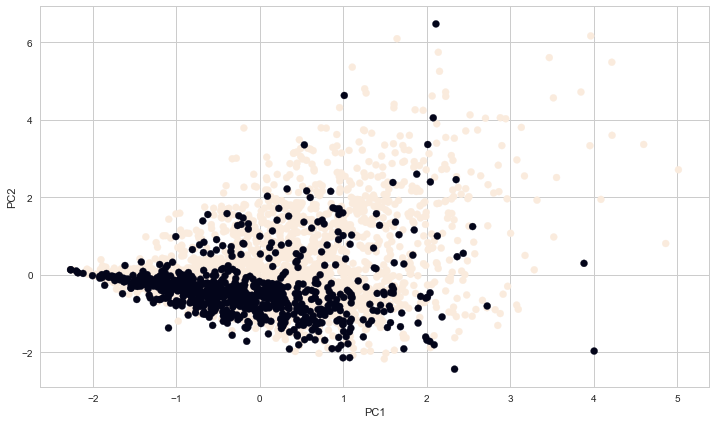

In [29]:

#Plotting the data of TF_IDF and Word2vec features together as SVD components
plt.scatter(X1[:, 0], X1[:, 1], c=reviews_by_component_original['review_sentiment'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [30]:
# To schuffle samples
reviews_by_component = reviews_by_component_original.sample(frac=1, replace=False, random_state=2)
reviews_by_component.reset_index(drop=True, inplace=True)

# Splitting data into X and Y
Y = reviews_by_component['review_sentiment']
X = reviews_by_component.loc[:, ~(reviews_by_component.columns).isin(['review_sentiment'])]

In [31]:
reviews_by_component.head()

,0,1,2,3,4,5,6,7,8,9,...,935,936,937,938,939,940,941,942,943,review_sentiment
0,0.154739,-0.069379,-0.013639,-0.016321,-0.014441,-0.003122,0.016701,-0.064142,0.045647,-0.022791,...,0.016711,0.009012,0.000275,0.014532,0.013687,0.012035,-0.006840,0.021039,-0.018497,0
1,0.088316,-0.056298,-0.004550,0.034433,0.050872,-0.017216,-0.024869,-0.120398,0.063764,-0.058997,...,-0.021261,0.006057,-0.018276,-0.030733,-0.018346,0.007377,-0.008845,0.015949,0.039801,1
2,0.036731,-0.007010,-0.011340,-0.024377,0.003080,0.009468,0.003620,0.011563,0.023341,-0.011520,...,-0.004937,-0.024737,0.011655,0.000270,-0.005428,0.016348,-0.044036,0.020392,0.010062,1
3,0.275050,0.145746,-0.085841,-0.091852,0.002310,-0.054425,-0.062662,-0.030652,0.027654,0.018065,...,0.000222,-0.012673,0.019626,-0.020153,0.010371,0.019118,-0.020469,-0.021906,-0.004467,1
4,0.154744,-0.008331,0.104939,-0.155968,-0.031744,0.130647,-0.128294,0.031539,0.025542,-0.059660,...,0.001968,-0.008997,0.000863,-0.023276,0.013602,-0.005457,0.002447,0.001808,-0.001470,1


In [32]:
print('Number of review samples per each class\n {}'.format(Counter(Y)))

Number of review samples per each class
 Counter({1: 2944, 0: 769})


There is a lot of class imbalance here. Need to correct the problem before going further by over sampling and under sampling (SMOTE).

In [33]:
# SMOTE i.e oversampling and undersampling
smote = SMOTE(random_state=1)
X, Y = smote.fit_resample(X, Y)
print('Number of review samples per each class\n {}'.format(Counter(Y)))

Number of review samples per each class
 Counter({0: 2944, 1: 2944})


Smote does minority oversampling...but adds them all together at the end causing a non-randomness in the samples.
Need to shuffle again

In [34]:
#Shuffle again 
X = pd.DataFrame(X)
Y = pd.DataFrame(Y,columns=['sentiment'])
Y = Y['sentiment']

Xt = X.sample(frac=1, replace=False, random_state=2)
Yt = Y.sample(frac=1, replace=False, random_state=2)

Xt.reset_index(drop=True, inplace=True)
Yt.reset_index(drop=True, inplace=True)

#Saving the data for further use with clustering as Xs and Ys
X = Xt
Y = Yt

In [35]:
print('Number of review samples per each class\n {}'.format(Counter(np.array(Y))))

Number of review samples per each class
 Counter({1: 2944, 0: 2944})


### 3) Evaluation of models with TF_IDF features


###  Model assessment and evalution with other models

Before going with Model assessment created a function to handle this everytime we test a model

In [36]:
def model(mod, X=X, Y=Y):
    model_object=mod
    #Data split to Train and test
    global X_train, X_test, y_train, y_test
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=3)
    model_object.fit(X_train, y_train)
    print ("Model train score is %0.2f" % (model_object.score(X_train, y_train)) )
    evaluation(model_object)
    return model_object

def evaluation(model_object):
    #Evalution of model
    score=cross_val_score(X=X_test, y=y_test, estimator=model_object, cv=10)
    print ('\nCross_validation scores below :\n', score)
    print("\nMean/test accuracy: %0.2f (+/- %0.2f)\n" % (score.mean(), score.std() * 2))
    
    y_pred=model_object.predict(X_test)
  
   #Plotting the ROC-AUC curve   
    
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', linewidth=4,label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right', fancybox=True, fontsize='large')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    fpr=fpr[1]
    tpr=tpr[1]
    print ("\n_______________Contingency table analysis:_________\n")
    print ('The sensitivity i.e true positives is {0:2f}% '.format(tpr*100))
    print ('The specificity i.e true negatives is {0:2f}% '.format((1-fpr)*100))
    print ('The Type I error i.e. false negatives is {0:2f}% '.format((1-tpr)*100))
    print ('The Type II error i.e. false positives is {0:2f}% '.format(fpr*100))
    return

In [37]:
### Logistic Regression

/Users/Sri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Model train score is 0.99


/Users/Sri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/Sri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/Sri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/Sri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/Sri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached w


Cross_validation scores below :
 [0.80405405 0.79054054 0.79054054 0.79054054 0.78378378 0.81632653
 0.84353741 0.79452055 0.79452055 0.82191781]

Mean/test accuracy: 0.80 (+/- 0.04)



/Users/Sri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


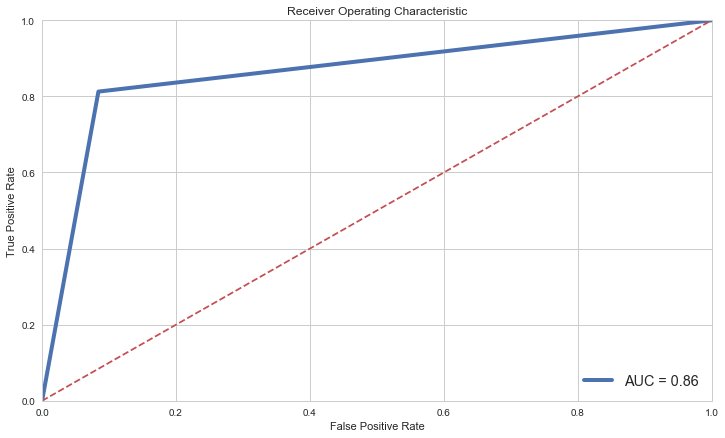


_______________Contingency table analysis:_________

The sensitivity i.e true positives is 81.258367% 
The specificity i.e true negatives is 91.586207% 
The Type I error i.e. false negatives is 18.741633% 
The Type II error i.e. false positives is 8.413793% 


LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=200, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [38]:
model(LogisticRegression(C=1e9, solver='saga', max_iter=200))

In [39]:
### Gradient Boost Classifier

Model train score is 0.91

Cross_validation scores below :
 [0.84459459 0.78378378 0.81756757 0.78378378 0.7972973  0.82312925
 0.78231293 0.79452055 0.78082192 0.84246575]

Mean/test accuracy: 0.81 (+/- 0.05)



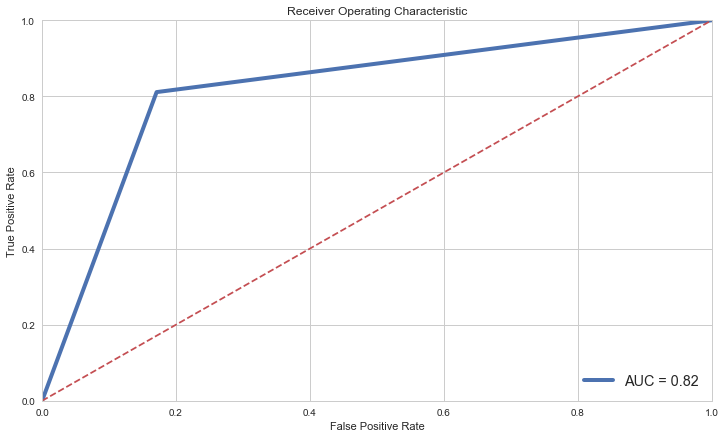


_______________Contingency table analysis:_________

The sensitivity i.e true positives is 81.124498% 
The specificity i.e true negatives is 82.896552% 
The Type I error i.e. false negatives is 18.875502% 
The Type II error i.e. false positives is 17.103448% 


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [40]:
params = {'n_estimators': 100,
          'max_depth': 2,
          'loss': 'deviance'}
model(ensemble.GradientBoostingClassifier(**params))

Model train score is 0.50

Cross_validation scores below :
 [0.50675676 0.50675676 0.50675676 0.50675676 0.50675676 0.51020408
 0.51020408 0.50684932 0.50684932 0.50684932]

Mean/test accuracy: 0.51 (+/- 0.00)



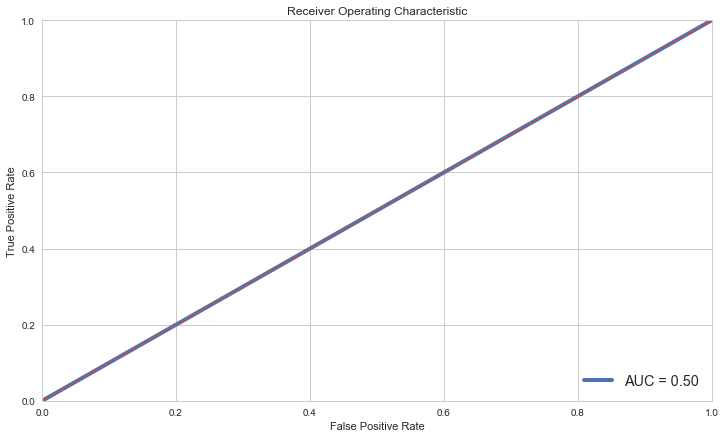


_______________Contingency table analysis:_________

The sensitivity i.e true positives is 100.000000% 
The specificity i.e true negatives is 0.000000% 
The Type I error i.e. false negatives is 0.000000% 
The Type II error i.e. false positives is 100.000000% 


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [41]:
model(SVC(gamma='auto'))

In [42]:
### Random Forest Classifier

Model train score is 0.99

Cross_validation scores below :
 [0.87162162 0.79054054 0.78378378 0.77027027 0.89189189 0.83673469
 0.79591837 0.85616438 0.86986301 0.84931507]

Mean/test accuracy: 0.83 (+/- 0.08)



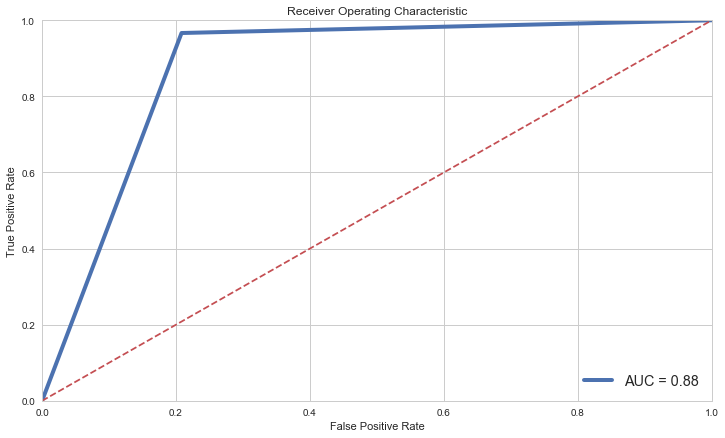


_______________Contingency table analysis:_________

The sensitivity i.e true positives is 96.653280% 
The specificity i.e true negatives is 79.172414% 
The Type I error i.e. false negatives is 3.346720% 
The Type II error i.e. false positives is 20.827586% 


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [43]:
params={'max_depth': 7, 'max_features': 'log2', 'n_estimators': 200}

model(RandomForestClassifier(**params))

Using neural networks model for text classification

Model train score is 1.00


/Users/Sri/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/Sri/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/Sri/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/Sri/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  %


Cross_validation scores below :
 [0.7972973  0.79054054 0.72972973 0.71621622 0.77027027 0.78231293
 0.8707483  0.82191781 0.78082192 0.82876712]

Mean/test accuracy: 0.79 (+/- 0.09)



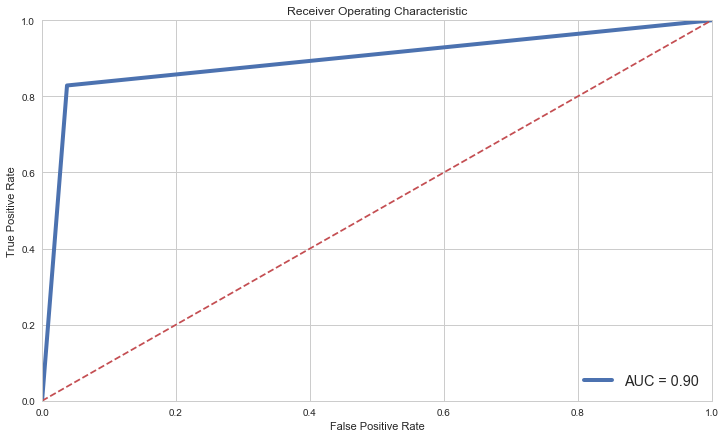


_______________Contingency table analysis:_________

The sensitivity i.e true positives is 82.864793% 
The specificity i.e true negatives is 96.275862% 
The Type I error i.e. false negatives is 17.135207% 
The Type II error i.e. false positives is 3.724138% 


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(1000, 4), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [44]:
model(MLPClassifier(hidden_layer_sizes=(1000, 4)), Xt, Yt)

The neural network MLP classifer does not perform better than other models discussed above.

The Random Forest Classifer gives the best test accuracy of 83%  and  AUC of 0.87 also low errors compared to other models.

### 4) Generation of word2vec features (Unsupervised technique)

### Word2Vec Unsupervised Feature generation

In [45]:
# We cannot use list of strings for word2vec. need list of lists
for item in all_reviews_list_cleaned_doc:
    print (type (item))
    break

<class 'str'>


In [46]:
# Cleaning the texts and making the reviews as a list of lists needed for word2vec.

all_reviews_list_cleaned_doc = []
all_reviews_positive_list_cleaned_doc = []
all_reviews_negative_list_cleaned_doc = []
temp=[]         
for review in all_reviews_positive_list_doc:
    for token in review:
        if not token.is_punct and not token.is_space and not token.is_stop and  token.is_alpha:
            temp.append(token.text.lower())
    all_reviews_positive_list_cleaned_doc.append(temp)
    temp=[]
        
for review in all_reviews_negative_list_doc:
    for token in review:
        if not token.is_punct and not token.is_space and not token.is_stop and  token.is_alpha:
            temp.append(token.text.lower())
    all_reviews_negative_list_cleaned_doc.append(temp)
    temp=[]
all_reviews_list_cleaned_doc = all_reviews_positive_list_cleaned_doc+all_reviews_negative_list_cleaned_doc

In [47]:
#Just checking whether each item in the list is a list or not since it is a requirement for Word2Vec
for item in all_reviews_list_cleaned_doc:
    print ((item))
    print (type(item))
    break

['chance', 'watch', 'glee', 'tv', 'downloading', 'episodes', 'kindle', 'fire', 'great', 'option']
<class 'list'>


In [48]:
len(all_reviews_list_cleaned_doc)

3713

In [49]:
import gensim 
model_W2V = gensim.models.Word2Vec (all_reviews_list_cleaned_doc, size=200, window=5, min_count=2, workers=10)

model_W2V.train(all_reviews_list_cleaned_doc,total_examples=len(all_reviews_list_cleaned_doc),epochs=10)

(1335173, 1498800)

In [50]:
vocab=model_W2V.wv.vocab.keys()

In [51]:
print (type(vocab))

<class 'dict_keys'>


In [52]:

model_W2V.wv.most_similar (positive='cool')

[('complaint', 0.9989672303199768),
 ('mistake', 0.9986713528633118),
 ('enthusiasm', 0.9982789754867554),
 ('brutally', 0.9982788562774658),
 ('lose', 0.9980556964874268),
 ('onscreen', 0.9979897737503052),
 ('thrilling', 0.9979183673858643),
 ('garbage', 0.9978166818618774),
 ('hurts', 0.9977137446403503),
 ('hilarious', 0.9976052045822144)]

In [53]:
model_W2V.wv['cool'] # Wanted to see the word to vector form

array([ 2.67219484e-01, -1.58632353e-01, -2.91430086e-01,  1.14552557e-01,
        1.88147724e-01, -9.29439440e-02,  8.29129964e-02, -1.18234590e-01,
        7.99653530e-02, -2.09476411e-01, -2.03054938e-02,  4.42208380e-01,
       -3.40038776e-01,  4.31918889e-01, -1.42261535e-01,  2.24808902e-01,
        4.45140868e-01,  4.11400646e-01,  2.99001150e-02,  1.17190480e-01,
       -1.23237543e-01, -3.46555173e-01,  2.54322350e-01, -2.35353753e-01,
       -1.97370067e-01,  2.89387666e-02,  1.20946482e-01,  4.38317329e-01,
       -9.75047983e-03, -1.22803330e-01, -1.27828762e-01, -1.08565181e-01,
        3.04708451e-01, -4.30867493e-01,  6.54278472e-02,  3.37389112e-01,
        1.11947708e-01, -1.29103541e-01, -2.81373769e-01,  3.02840471e-01,
       -1.00805618e-01,  1.20829277e-01,  4.70840216e-01,  2.24207550e-01,
       -6.14693046e-01, -4.45673257e-01,  1.91527739e-01, -3.27652723e-01,
        6.59519285e-02,  6.45895228e-02, -2.46020377e-01,  5.45897484e-02,
       -7.75597617e-02, -

In [54]:
model_W2V.wv['excellent']

array([ 0.33146605, -0.283363  , -0.8763089 ,  0.08312421, -0.15888895,
       -0.2598025 ,  0.08279318,  0.02337111, -0.13485765, -0.37505543,
       -0.33996338,  0.70750797, -0.41198808,  0.306425  , -0.06134433,
        0.44035423,  0.23283768,  0.5454379 , -0.00843526, -0.0224219 ,
       -0.2422199 , -0.3823859 ,  0.53487134, -0.8352388 , -0.2847057 ,
        0.00665713, -0.21396662,  0.46653688,  0.23929933,  0.03606966,
        0.0642606 , -0.02072423,  0.4236841 , -0.46962038,  0.12292181,
        0.77069175,  0.513118  , -0.18272136, -0.29361537,  0.24273401,
       -0.23155154,  0.1625212 ,  0.15384583,  0.29292592, -1.0038419 ,
        0.21691771, -0.16184466, -0.4237653 , -0.38742477,  0.450179  ,
       -0.40478593, -0.28256166, -0.14789927, -0.02276699,  0.24520706,
       -0.4833995 , -0.7016565 , -0.15820308, -0.30766216,  0.69704235,
        0.57529384,  0.21721388,  0.04083477,  0.01661964, -0.01801731,
        0.63573515,  0.40834755,  0.3685497 ,  0.5741533 , -0.70

In [55]:
# Normalizes the word2vec vectors
model_W2V.init_sims(replace=True)
error=0
# remove out-of-vocab words
word2vecFeature = np.zeros((len(all_reviews_list_cleaned_doc),200))
for i,doc in enumerate(all_reviews_list_cleaned_doc): 
    
    doc = [word for word in doc if word in vocab]
    if len(doc)!=0:
        word2vecFeature[i,:] = np.mean(model_W2V.wv[doc],axis=0)
    else:
        error+=1
print ('Number of errors found (with empty lists I guess...)', error)
word2vecFeature = pd.DataFrame(word2vecFeature)
word2vecFeature.head()

Number of errors found (with empty lists I guess...) 3


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.053165,-0.044418,-0.117599,0.032338,0.027087,-0.031658,0.041598,0.019370,-0.007252,-0.078339,...,-0.008153,0.020553,0.053241,-0.002034,-0.025585,0.048677,-0.025925,0.036062,0.023028,0.058723
1,0.071826,-0.045872,-0.062271,0.026979,0.057861,-0.016582,0.019669,-0.035284,0.034092,-0.056321,...,-0.014832,0.046096,0.077660,-0.003144,-0.029757,0.071501,-0.046165,0.028766,0.040783,0.087551
2,0.057588,-0.041498,-0.074340,0.032790,0.052617,-0.021248,0.034877,-0.007785,0.020628,-0.068742,...,-0.010602,0.049700,0.053434,-0.016089,-0.035010,0.085876,-0.045529,0.050262,0.027889,0.052976
3,0.059676,-0.047220,-0.140444,0.041647,0.032089,-0.031695,0.051668,0.020688,-0.027284,-0.074259,...,-0.019022,0.034238,0.043653,-0.016778,-0.033777,0.067346,-0.014650,0.055363,0.019901,0.027403
4,0.064571,-0.047721,-0.089707,0.032681,0.040985,-0.023750,0.028301,-0.012288,0.010581,-0.067225,...,-0.011477,0.033860,0.076130,-0.000853,-0.024515,0.050961,-0.032988,0.022489,0.037911,0.077184


In [56]:
word2vecFeature.shape

(3713, 200)

In [57]:
# Adding the outcome variable to the data.
word2vecFeature['review_sentiment'] = 0
word2vecFeature.loc[0:len(all_reviews_positive_list_cleaned_doc)-1, 'review_sentiment'] = 1
word2vecFeature.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,review_sentiment
0,0.053165,-0.044418,-0.117599,0.032338,0.027087,-0.031658,0.041598,0.019370,-0.007252,-0.078339,...,0.020553,0.053241,-0.002034,-0.025585,0.048677,-0.025925,0.036062,0.023028,0.058723,1
1,0.071826,-0.045872,-0.062271,0.026979,0.057861,-0.016582,0.019669,-0.035284,0.034092,-0.056321,...,0.046096,0.077660,-0.003144,-0.029757,0.071501,-0.046165,0.028766,0.040783,0.087551,1
2,0.057588,-0.041498,-0.074340,0.032790,0.052617,-0.021248,0.034877,-0.007785,0.020628,-0.068742,...,0.049700,0.053434,-0.016089,-0.035010,0.085876,-0.045529,0.050262,0.027889,0.052976,1
3,0.059676,-0.047220,-0.140444,0.041647,0.032089,-0.031695,0.051668,0.020688,-0.027284,-0.074259,...,0.034238,0.043653,-0.016778,-0.033777,0.067346,-0.014650,0.055363,0.019901,0.027403,1
4,0.064571,-0.047721,-0.089707,0.032681,0.040985,-0.023750,0.028301,-0.012288,0.010581,-0.067225,...,0.033860,0.076130,-0.000853,-0.024515,0.050961,-0.032988,0.022489,0.037911,0.077184,1


In [58]:
# Slitting into x and y
Y = word2vecFeature['review_sentiment']
X = word2vecFeature.loc[:, ~(word2vecFeature.columns).isin(['review_sentiment'])] 
print('Number of review samples per each class\n {}'.format(Counter(Y)))

Number of review samples per each class
 Counter({1: 2944, 0: 769})


In [59]:
# SMOTE i.e oversampling and undersampling
smote = SMOTE(random_state=1)
X, Y = smote.fit_resample(X, Y)
print('Number of review samples per each class\n {}'.format(Counter(Y)))

Number of review samples per each class
 Counter({1: 2944, 0: 2944})


Smote does minority oversampling...but adds them all together at the end causing a non-randomness in the samples.
Need to shuffle again

In [60]:
#Shuffle again 
X = pd.DataFrame(X)
Y = pd.DataFrame(Y,columns=['review_sentiment'])
Y = Y['review_sentiment']

Xw = X.sample(frac=1, replace=False, random_state=2)
Yw = Y.sample(frac=1, replace=False, random_state=2)

Xw.reset_index(drop=True, inplace=True)
Yw.reset_index(drop=True, inplace=True)

#Saving the data for later use for clustering

X = Xw
Y = Yw

In [61]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.067115,-0.041064,-0.051694,0.020040,0.058285,-0.015751,0.023961,-0.025461,0.037826,-0.059108,...,-0.010306,0.043566,0.067760,-0.004531,-0.034099,0.081298,-0.052611,0.039585,0.032905,0.076259
1,0.055400,-0.043391,-0.118883,0.039241,0.033263,-0.030031,0.045987,0.016363,-0.012721,-0.071169,...,-0.018308,0.039160,0.046830,-0.021106,-0.036229,0.072426,-0.025697,0.054585,0.017842,0.036400
2,0.072075,-0.044423,-0.056853,0.022951,0.053448,-0.018039,0.014349,-0.040364,0.036412,-0.052131,...,-0.011353,0.035151,0.083359,0.005574,-0.024951,0.060012,-0.044405,0.016254,0.041300,0.096756
3,0.058933,-0.037089,-0.035970,0.021327,0.067854,-0.012088,0.021515,-0.017579,0.039561,-0.063464,...,-0.008515,0.057729,0.060118,-0.017601,-0.045258,0.096277,-0.057548,0.045253,0.032486,0.066830
4,0.072005,-0.049308,-0.121620,0.038888,0.031320,-0.027776,0.027141,-0.026745,-0.009541,-0.052367,...,-0.021882,0.027464,0.094453,0.007276,-0.019133,0.039259,-0.019385,0.011276,0.038856,0.091373


### 5) Evaluation of models with Word2vec features


###  Model assessment and evalution with other models

In [62]:
### Gradient Boost Classifier

Model train score is 0.91

Cross_validation scores below :
 [0.84459459 0.78378378 0.81756757 0.77702703 0.7972973  0.82312925
 0.78231293 0.79452055 0.78082192 0.84246575]

Mean/test accuracy: 0.80 (+/- 0.05)



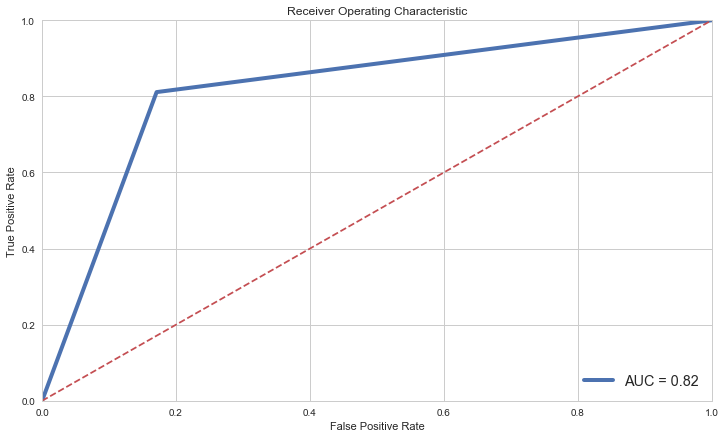


_______________Contingency table analysis:_________

The sensitivity i.e true positives is 81.124498% 
The specificity i.e true negatives is 82.896552% 
The Type I error i.e. false negatives is 18.875502% 
The Type II error i.e. false positives is 17.103448% 


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [63]:
params = {'n_estimators': 100,
          'max_depth': 2,
          'loss': 'deviance'}
model (ensemble.GradientBoostingClassifier(**params))

In [64]:
### Random Forest Classifier

Model train score is 0.99

Cross_validation scores below :
 [0.85135135 0.81081081 0.77027027 0.75675676 0.87162162 0.85034014
 0.79591837 0.84931507 0.85616438 0.80821918]

Mean/test accuracy: 0.82 (+/- 0.07)



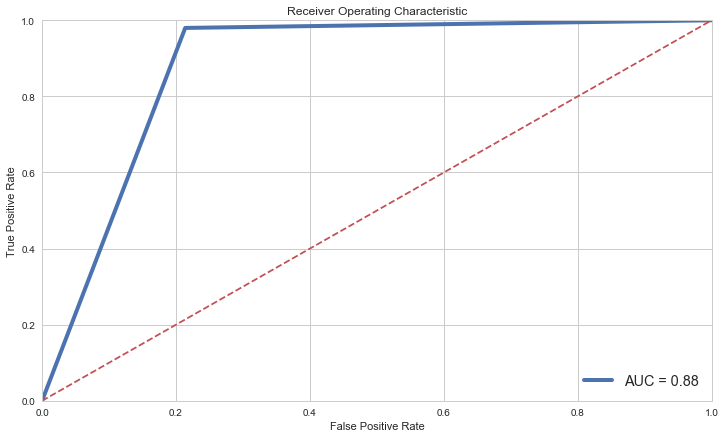


_______________Contingency table analysis:_________

The sensitivity i.e true positives is 97.991968% 
The specificity i.e true negatives is 78.620690% 
The Type I error i.e. false negatives is 2.008032% 
The Type II error i.e. false positives is 21.379310% 


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [65]:
params={'max_depth': 7, 'max_features': 'log2', 'n_estimators': 200}

model(RandomForestClassifier(**params))

In [66]:
### SVC

Model train score is 0.92

Cross_validation scores below :
 [0.81756757 0.78378378 0.77027027 0.83108108 0.81081081 0.81632653
 0.88435374 0.83561644 0.78082192 0.82191781]

Mean/test accuracy: 0.82 (+/- 0.06)



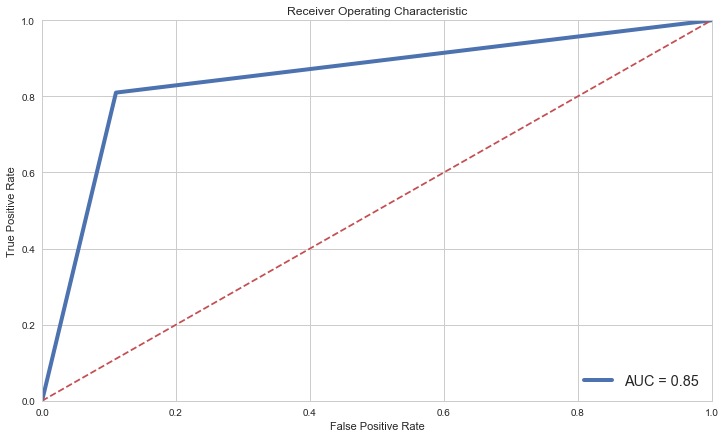


_______________Contingency table analysis:_________

The sensitivity i.e true positives is 80.990629% 
The specificity i.e true negatives is 88.965517% 
The Type I error i.e. false negatives is 19.009371% 
The Type II error i.e. false positives is 11.034483% 


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [67]:
model(SVC(gamma='auto',kernel='linear' ))

SVC and Random Forest classifier give around similar accuracies and low errors with greater AUC.

#####  With word2vec alone an accuracy of 75% is got . Now howabout if we add the TFIDF features.

In [68]:
# Slitting into x and y

word2vecFeat_TFIDF=pd.DataFrame()

columns_to_copy = reviews_by_component_original.columns[~(reviews_by_component_original.columns).isin(['review_sentiment'])]

for name in columns_to_copy:
    word2vecFeat_TFIDF[str(name)+'tf_idf'] = reviews_by_component_original[name]
    
word2vecFeat_TFIDF['review_sentiment'] = reviews_by_component_original['review_sentiment']

Y = word2vecFeat_TFIDF['review_sentiment']
X = word2vecFeat_TFIDF.loc[:, ~(word2vecFeat_TFIDF.columns).isin(['review_sentiment'])] 
print('Number of review samples per each class\n {}'.format(Counter(Y)))
word2vecFeat_TFIDF.head()

Number of review samples per each class
 Counter({1: 2944, 0: 769})


,0tf_idf,1tf_idf,2tf_idf,3tf_idf,4tf_idf,5tf_idf,6tf_idf,7tf_idf,8tf_idf,9tf_idf,...,935tf_idf,936tf_idf,937tf_idf,938tf_idf,939tf_idf,940tf_idf,941tf_idf,942tf_idf,943tf_idf,review_sentiment
0,0.115615,0.004049,0.103476,-0.062401,-0.013988,0.047439,0.177461,0.066759,0.020416,-0.032672,...,-0.003255,-0.061191,0.010662,0.027445,0.015926,-0.021797,0.031622,0.014612,-0.045330,1
1,0.120566,-0.053737,-0.001317,-0.034567,0.021570,-0.010941,-0.054511,-0.042210,0.050047,-0.037421,...,-0.015296,0.002695,0.011004,-0.022448,-0.004086,0.029151,0.008265,0.003922,-0.033292,1
2,0.075692,-0.014836,0.004020,-0.027570,-0.053195,0.009198,0.014225,0.013040,0.032840,-0.013623,...,0.015709,0.015401,-0.002247,-0.009408,0.001838,-0.017763,0.002108,0.024650,0.004755,1
3,0.082911,0.052078,0.015170,-0.029657,0.033247,0.032388,-0.002993,-0.012864,0.076118,0.292056,...,0.004581,-0.000481,0.003725,-0.000329,-0.005888,-0.002883,-0.002551,-0.006335,0.007499,1
4,0.139458,-0.007920,0.118945,-0.050133,0.041432,-0.017664,0.128057,-0.026854,0.012628,0.002483,...,-0.002748,0.045457,-0.016063,0.023017,0.015098,0.001143,-0.026591,0.038174,0.035804,1


In [69]:
# SMOTE i.e oversampling and undersampling
smote = SMOTE(random_state=1)
X, Y = smote.fit_resample(X, Y)
print('Number of review samples per each class\n {}'.format(Counter(Y)))

Number of review samples per each class
 Counter({1: 2944, 0: 2944})


Smote does minority oversampling...but adds them all together at the end causing a non-randomness in the samples.
Need to shuffle again

In [70]:
#Shuffle again 
X = pd.DataFrame(X)
Y = pd.DataFrame(Y,columns=['review_sentiment'])


X = X.sample(frac=1, replace=False, random_state=2)
Y = Y.sample(frac=1, replace=False, random_state=2)

X.reset_index(drop=True, inplace=True)
Y.reset_index(drop=True, inplace=True)

Y = Y['review_sentiment']

In [71]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,934,935,936,937,938,939,940,941,942,943
0,0.041643,-0.024243,-0.022089,-0.021928,-0.011830,0.002159,-0.014032,0.020416,0.017496,-0.033589,...,-0.020322,0.000136,0.012821,-0.024498,-0.001861,0.018260,0.030704,0.007863,-0.010658,0.008174
1,0.071040,0.006954,0.005880,-0.049835,-0.029401,0.032707,0.015765,0.052946,0.031004,-0.017614,...,-0.026019,-0.013876,-0.024549,0.018089,0.016216,0.044015,-0.008261,0.023378,-0.002685,0.023378
2,0.069669,-0.030245,0.025647,0.042086,-0.015581,-0.041777,-0.008634,0.022595,0.000014,0.011494,...,-0.017793,-0.008902,-0.019453,-0.005967,0.015125,0.006449,-0.012786,-0.010978,0.022794,-0.026150
3,0.066358,-0.040203,-0.012283,-0.052076,-0.009519,0.020295,0.018360,0.016447,-0.002861,-0.057880,...,-0.011629,0.001156,0.008839,-0.015265,0.013075,-0.001401,0.001147,0.009312,-0.010173,-0.008396
4,0.092929,-0.001117,0.075699,-0.003445,0.072645,-0.076699,0.040243,0.007253,-0.013763,-0.014840,...,-0.003490,0.004828,-0.000730,0.002113,-0.012350,-0.000494,0.004600,0.016476,0.004028,0.006098


In [72]:
# Needs to be standardized by scaling
#from sklearn.preprocessing import scale
X1 = scale(X)

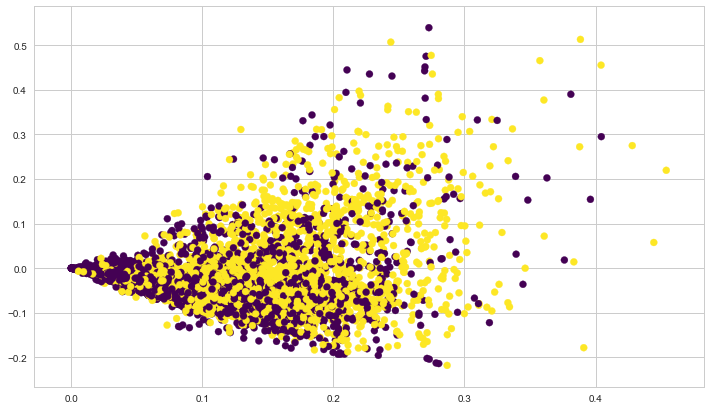

In [73]:
#Plotting the data of TF_IDF and Word2vec features together
# Getting the X data from TF-IDF data and converting into an array for plotting i.e PC1 and PC2
X1=np.array(Xt)
plt.scatter(X1[:, 0], X1[:, 1], c=Y, cmap='viridis')
plt.show()

In [74]:
### Gradient Boost Classifier

Model train score is 0.91

Cross_validation scores below :
 [0.84459459 0.78378378 0.81756757 0.78378378 0.7972973  0.82312925
 0.78231293 0.79452055 0.78082192 0.84246575]

Mean/test accuracy: 0.81 (+/- 0.05)



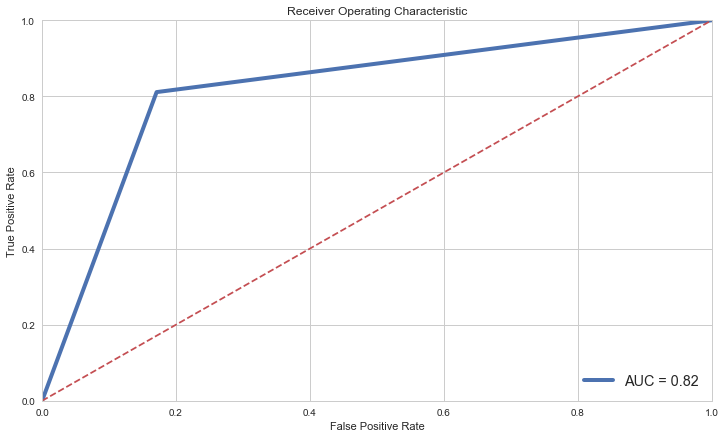


_______________Contingency table analysis:_________

The sensitivity i.e true positives is 81.124498% 
The specificity i.e true negatives is 82.896552% 
The Type I error i.e. false negatives is 18.875502% 
The Type II error i.e. false positives is 17.103448% 


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [75]:
params = {'n_estimators': 100,
          'max_depth': 2,
          'loss': 'deviance'}
model(ensemble.GradientBoostingClassifier(**params))

Still the accuracy was only around 81% with Gradient boost classifier..so proceeded with TFIDF data alone for further data analysis.

## 6) Clustering of data and Evaluation

#### All the data used for TF-IDF have undegone dimension reduction by SVD and so the first three components are used here to visualize

#### Before going with the clustering lets us first define some functions to make to easier to build and analyse the clusters

In [76]:
from sklearn.cluster import KMeans
from sklearn.cluster import spectral_clustering
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MeanShift, estimate_bandwidth
from scipy import cluster
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score



In [77]:
def cluster_plot(mod, X=Xt, Y=Yt):
    print ('\nProjecting the data on a 3D scatter plot')
    sns.set(rc={'figure.figsize':(15,10)}, style='whitegrid', color_codes=True)
    #Plotting the TF_IDF data i.e Xt
    X=np.array(X)
    mod.fit(X)
    labels = mod.labels_
    centers=model_k.cluster_centers_

    fig = plt.figure(1, figsize=(15, 10))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    ax.scatter(X[:, 0], X[:, 1],X[:, 2],
               c=labels.astype(np.float), edgecolor='c', cmap = 'prism',marker='o', s=60)
    ax.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title('Text classification')
    ax.dist = 12
    plt.show()
    return


In [78]:
def clust_ROC_contingency(mod, X=X, Y=Y):
    model_object=mod
    #Data split to Train and test
    global X_train, X_test, y_train, y_test
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=3)
    model_object.fit(X_train)
    evaluation(model_object)
    return model_object

def evaluation(model_object):
    #Evalution of model
    y_pred=model_object.labels_
  
   #Plotting the ROC-AUC curve   
    fpr, tpr, threshold = metrics.roc_curve(y_train, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', linewidth=4,label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right', fancybox=True, fontsize='large')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    fpr=fpr[1]
    tpr=tpr[1]
    print ("\n_______________Contingency table analysis:_________\n")
    print ('The sensitivity i.e true positives is {0:2f}% '.format(tpr*100))
    print ('The specificity i.e true negatives is {0:2f}% '.format((1-fpr)*100))
    print ('The Type I error i.e. false negatives is {0:2f}% '.format((1-tpr)*100))
    print ('The Type II error i.e. false positives is {0:2f}% '.format(fpr*100))
    
    return

In [79]:
#Evaluating the kmeans clustering
# Evaluate the performance of the clusters

def cluster_adj_rand_index(mod):
    #Testing with the 25% holdout group
    X_train, X_test, y_train, y_test = train_test_split(Xt, Yt, test_size=0.25, random_state=3)
    mod.fit(X_train)
    y_pred=mod.labels_
    y_train=np.array(y_train)
    print ("________ADJUSTED RANDOM INDEX________\n")
    print ("ARI of 0 means random labelling and 1 indicates perfect labelling as expected")
    print('\nAdjusted Rand Index: {:0.2f}'.format(adjusted_rand_score(y_train, y_pred)))
    return

In [80]:
#Evaluating the stability of clustering method

def cluster_stability(mod):
    print ("______________CLUSTER SIMILARITY/STABILTIY___________\n")
    print('Testing how stable is the clustering method by Silhouette_score:')
    print ('The range of Silhouette score is from -1 for bad clusters to +1 for dense clusters.\n')
    for i in range(1,6):
        X_train, X_test, y_train, y_test = train_test_split(Xt, Yt, test_size=0.25, random_state=i)
        modClust = mod
        modClust.fit(X_train)
        labels = modClust.labels_
        print(metrics.silhouette_score(X_train, labels, metric='euclidean'))
    
    return

## K Means clustering

Elbow plot to find number of clusters 'k'

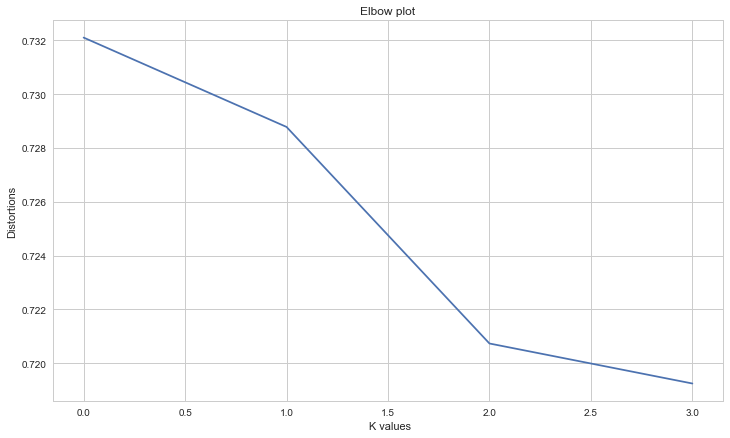

In [81]:
#plot variance for each value for 'k' between 1,5

initial = [cluster.vq.kmeans(Xt,i) for i in range(1,5)]
plt.plot([var for (cent,var) in initial])
plt.xlabel(' K values')
plt.ylabel('Distortions')
plt.title("Elbow plot")
plt.show()

The Elbow plot above shows that the elbow or the kink is at two clusters suggesting data segregation into 2 clusters which is great since that is what we want our model to expect to classify reviews by positive and negative.

In [82]:
# Projecting the data on a 2D scatter plot.

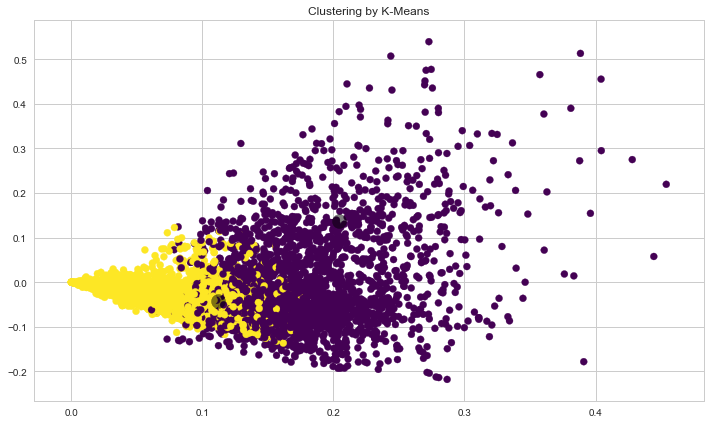

In [83]:
# Plotting the clusters using a Scipy tool for Kmeans. (Scipy has this method only for Kmeans clustering method)

cent, var = initial[1] # initial value of 1 means two clusters. i.e one has to be reduced 
model_k = KMeans(n_clusters=2, init='k-means++', n_init=20)
model_k.fit(Xt)
centers = model_k.cluster_centers_
#use vq() to get as assignment for each obs.
assignment,cdist = cluster.vq.vq(X1,cent)
plt.scatter(X1[:,0], X1[:,1], c=assignment, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.title ("Clustering by K-Means")
plt.show()


Projecting the data on a 3D scatter plot


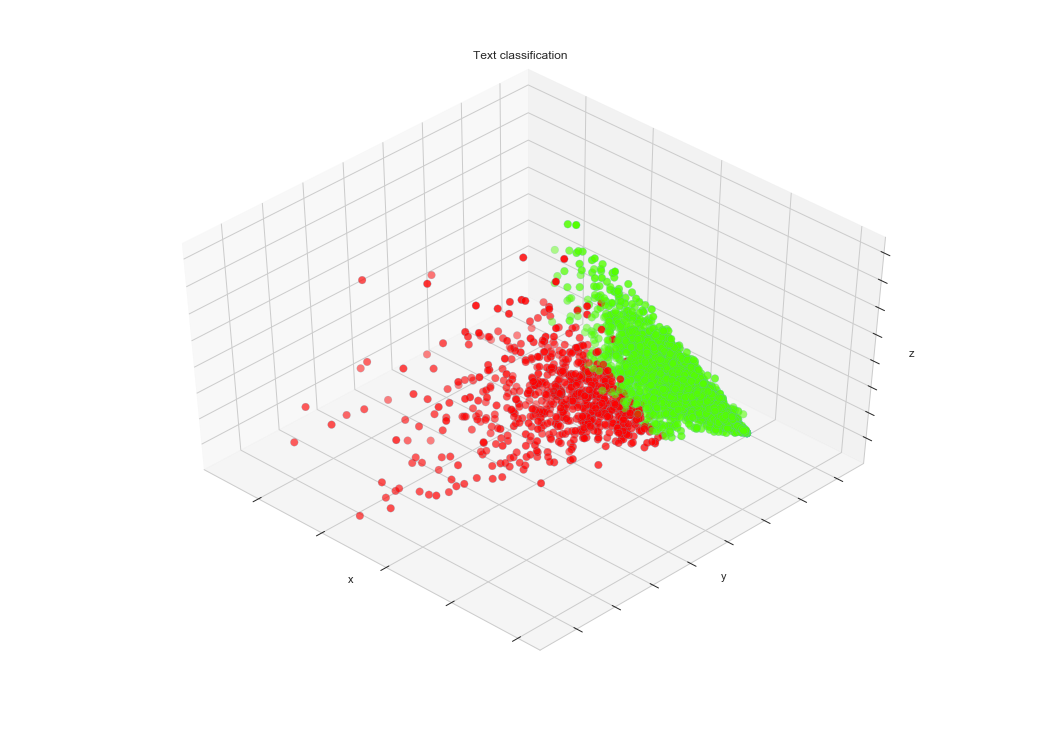

In [84]:
cluster_plot(KMeans(n_clusters=2, init='k-means++', n_init=20))

We cam clearly see two clusters of datapoints here in 3D than in 2D

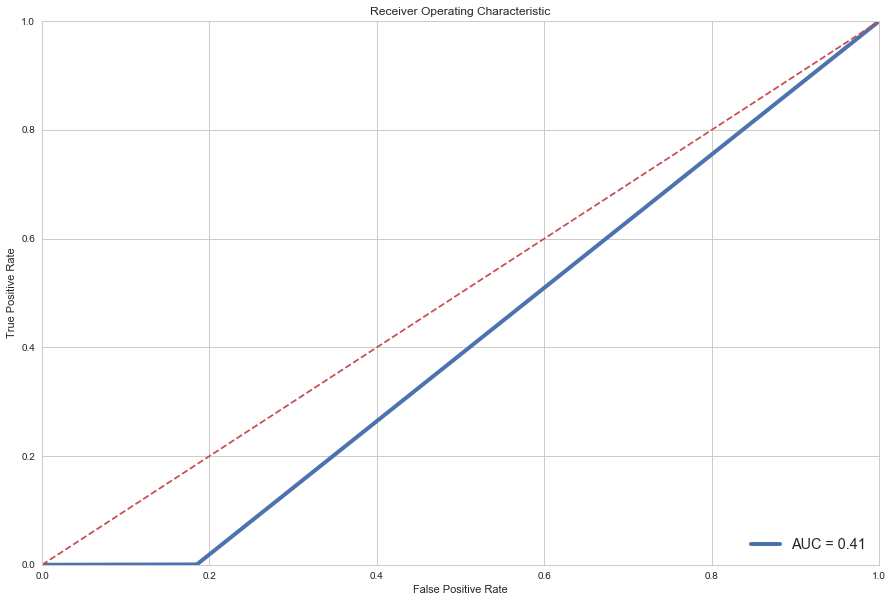


_______________Contingency table analysis:_________

The sensitivity i.e true positives is 0.067385% 
The specificity i.e true negatives is 81.506849% 
The Type I error i.e. false negatives is 99.932615% 
The Type II error i.e. false positives is 18.493151% 


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=20, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [85]:
clust_ROC_contingency(KMeans(n_clusters=2, init='k-means++', n_init=20))

In [86]:
cluster_adj_rand_index(KMeans(n_clusters=2, init='k-means++', n_init=20))

________ADJUSTED RANDOM INDEX________

ARI of 0 means random labelling and 1 indicates perfect labelling as expected

Adjusted Rand Index: 0.01


In [87]:
cluster_stability(KMeans(n_clusters=2, init='k-means++', n_init=20))

______________CLUSTER SIMILARITY/STABILTIY___________

Testing how stable is the clustering method by Silhouette_score:
The range of Silhouette score is from -1 for bad clusters to +1 for dense clusters.

-0.13039675009060356
0.05939298632362676
0.05714862179097361
-0.03270765579408601
-0.028730655570869543


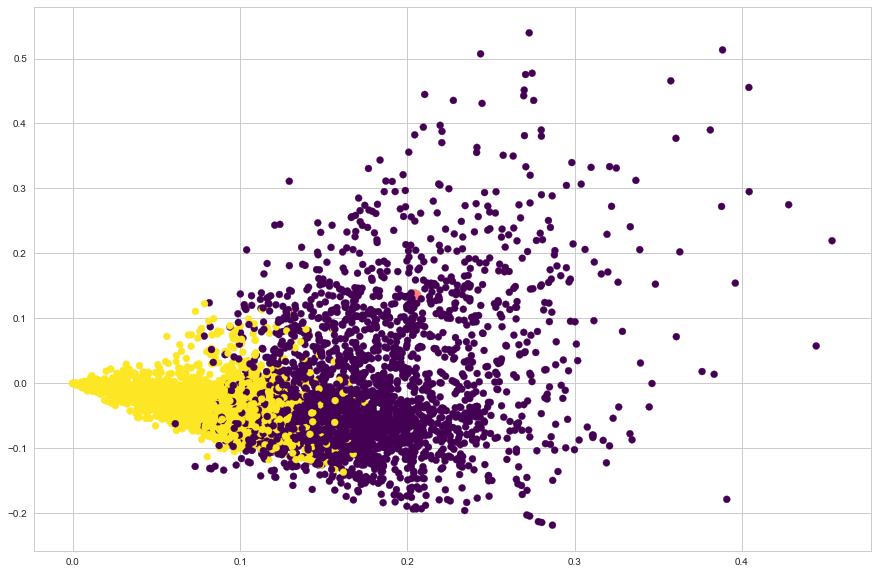

In [88]:
model_k =KMeans(n_clusters=2)
model_k.fit(Xt)
centers=model_k.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)
plt.scatter(X1[:,0], X1[:,1], c=assignment, cmap='viridis')
plt.show()

Methods of evaluation above show that Kmeans did not perform well in terms of stabilty as per the score range requirements and also clustering.

## Mean shift clustering

In [89]:
# Mean shift used here to estimate the number the clusters.,..It estimated based on data that it is all 
#one cluster
from sklearn.cluster import MeanShift, estimate_bandwidth

#Using the TF_IDF data which is Xt
bandwidth = estimate_bandwidth(Xt, quantile=0.1, n_samples=Xt.shape[0])
ms = MeanShift(bandwidth=1, bin_seeding=True)
ms.fit(Xt)
labels = ms.labels_
n_clusters_=len(np.unique(labels))
print("\nNumber of estimated clusters by the algorithm: {}".format(n_clusters_))


Number of estimated clusters by the algorithm: 1


Mean shift clusters the data as One cluster only.


Projecting the data on a 3D scatter plot


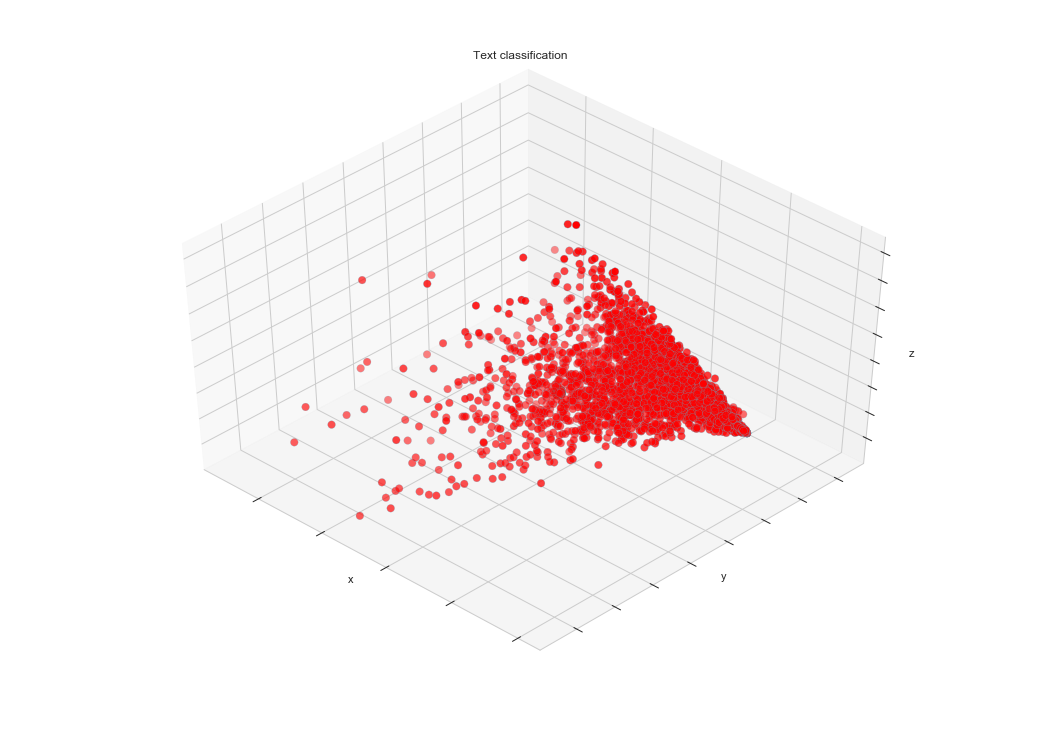

In [90]:
# Visualizing the cluster labelling of the Meanshift method using the model object ms
cluster_plot(MeanShift())

The above visualization and below evalution of clustering is doesnot make sense since meanshift determined the number of clusters to be one but the data we are trying to classify has binary output i.e positive or negative.

In [91]:
#clust_ROC_contingency(MeanShift())

In [92]:
#cluster_adj_rand_index(MeanShift())

In [93]:
# cluster_stability(MeanShift())

## Affinity Propagation clustering


Projecting the data on a 3D scatter plot


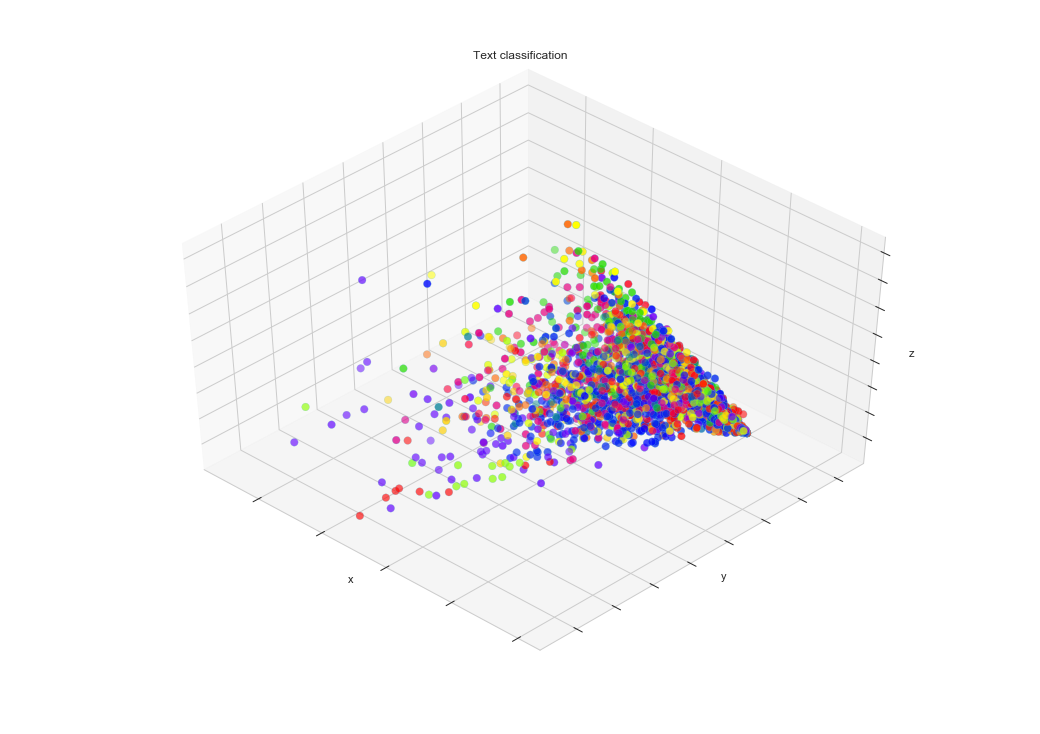

In [94]:
cluster_plot(AffinityPropagation())

#### Affinity propagation is known for predicting absurdly high clusters and we can see here that there lot of colours/cluster predicted.

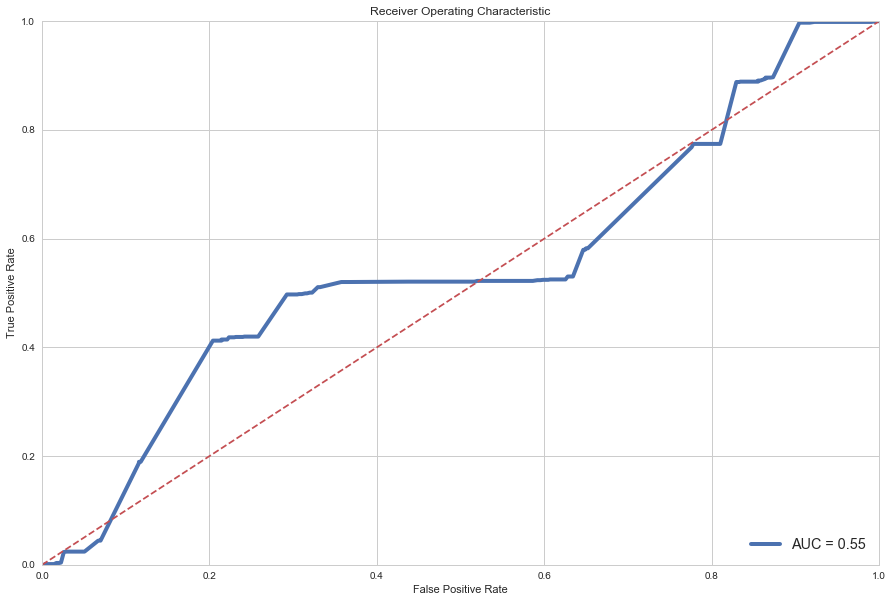


_______________Contingency table analysis:_________

The sensitivity i.e true positives is 0.000000% 
The specificity i.e true negatives is 99.863014% 
The Type I error i.e. false negatives is 100.000000% 
The Type II error i.e. false positives is 0.136986% 


AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
                    damping=0.5, max_iter=200, preference=None, verbose=False)

In [95]:
clust_ROC_contingency(AffinityPropagation())

In [96]:
cluster_adj_rand_index(AffinityPropagation())

________ADJUSTED RANDOM INDEX________

ARI of 0 means random labelling and 1 indicates perfect labelling as expected

Adjusted Rand Index: 0.03


In [97]:
cluster_stability(AffinityPropagation())

______________CLUSTER SIMILARITY/STABILTIY___________

Testing how stable is the clustering method by Silhouette_score:
The range of Silhouette score is from -1 for bad clusters to +1 for dense clusters.

0.07267113247396595
0.06409532264434398
0.06872209107103815
0.06955939789759807
0.07589080288269946


## Spectral clustering


Projecting the data on a 3D scatter plot


/Users/Sri/anaconda3/lib/python3.6/site-packages/scipy/sparse/csgraph/_laplacian.py:72: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)


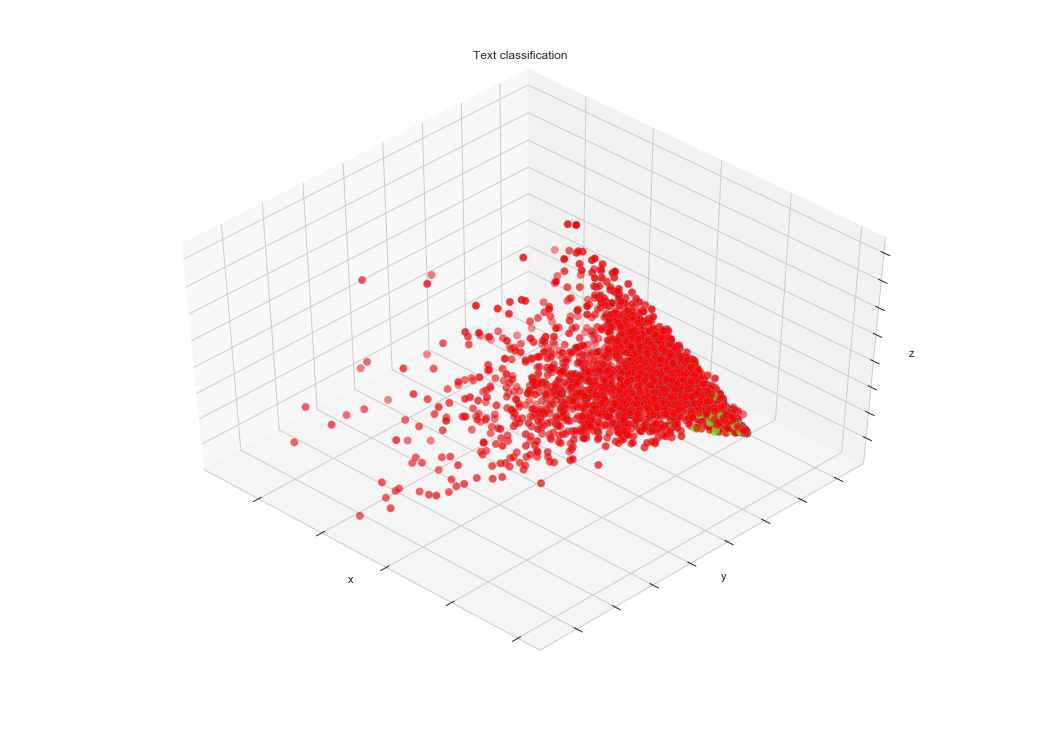

In [98]:
cluster_plot(SpectralClustering(n_clusters=2))

/Users/Sri/anaconda3/lib/python3.6/site-packages/scipy/sparse/csgraph/_laplacian.py:72: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)


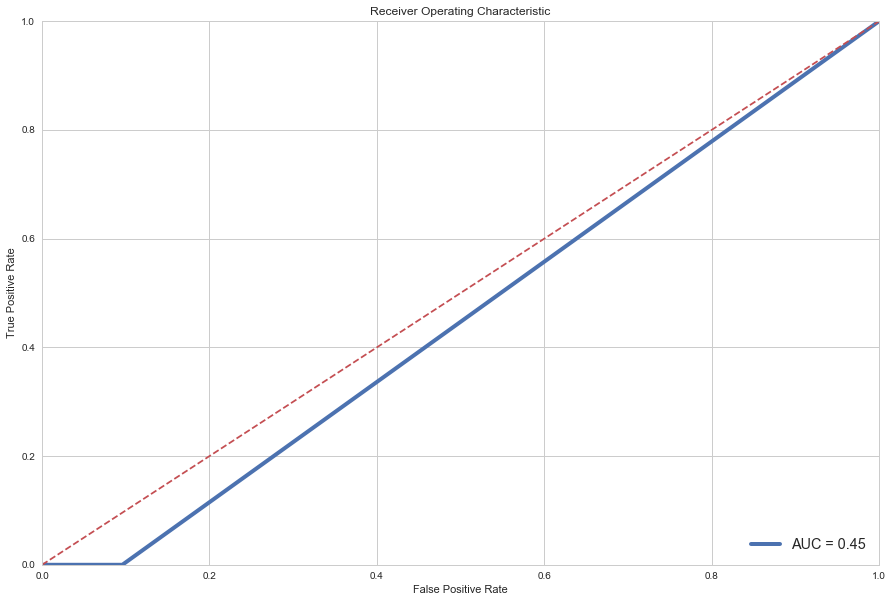


_______________Contingency table analysis:_________

The sensitivity i.e true positives is 0.000000% 
The specificity i.e true negatives is 90.410959% 
The Type I error i.e. false negatives is 100.000000% 
The Type II error i.e. false positives is 9.589041% 


SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver=None, eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=2, n_init=10, n_jobs=None,
                   n_neighbors=10, random_state=None)

In [99]:
clust_ROC_contingency(SpectralClustering(n_clusters=2))

In [100]:
cluster_adj_rand_index(SpectralClustering(n_clusters=2))

/Users/Sri/anaconda3/lib/python3.6/site-packages/scipy/sparse/csgraph/_laplacian.py:72: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)


________ADJUSTED RANDOM INDEX________

ARI of 0 means random labelling and 1 indicates perfect labelling as expected

Adjusted Rand Index: 0.01


In [101]:
cluster_stability(SpectralClustering(n_clusters=2))

______________CLUSTER SIMILARITY/STABILTIY___________

Testing how stable is the clustering method by Silhouette_score:
The range of Silhouette score is from -1 for bad clusters to +1 for dense clusters.



/Users/Sri/anaconda3/lib/python3.6/site-packages/scipy/sparse/csgraph/_laplacian.py:72: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)


-0.12970796631374798


/Users/Sri/anaconda3/lib/python3.6/site-packages/scipy/sparse/csgraph/_laplacian.py:72: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)


-0.1288385985680404


/Users/Sri/anaconda3/lib/python3.6/site-packages/scipy/sparse/csgraph/_laplacian.py:72: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)


-0.12757309051407148


/Users/Sri/anaconda3/lib/python3.6/site-packages/scipy/sparse/csgraph/_laplacian.py:72: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)


-0.12657635888633356


/Users/Sri/anaconda3/lib/python3.6/site-packages/scipy/sparse/csgraph/_laplacian.py:72: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)


-0.12595086536639546


We can get consistent reading by running several times but the similarity scores between cluster points is bad with almost all of the clustering techniques.

### 7) Conlusions: why Modelling is better than clustering. 

First of all, I like Clustering as a technique to visualize the datapoints and see how the datapoints fall as samples to give an idea. It is also a great unsupervised model for getting the feel of data. Secondly, it is good for unlabelled data to quickly know the groups. The two groups expected here the positive and reviews to some extent could be visualized. The demarcation or the boundary of the two groups was more evident in 3D graphing compared to 2D as in hyper dimensional space with mulit-dimensions it is hard to see that data in 2D and expect to find clusters or segregated groups. However, with 3D it was little better in visualizing the clusters and the boundarys or segregation into groups.

Clustering model methods are harder to evaluate compared to the all the supervised modelling methods. The Evalution or assessment of the results by clustering methods are mostly difficult to measure due to its inherent inexactness. When it comes to accuracy supervised models performed much better in accurately classifying the texts as positive or negative. This is especially seen with the errors in the contingency table, very high errors in classifying texts, where as the supervised models had very low error rates.

With RandIndex and Silhouette coefficient  were used to evaluate the similarity of datapoints in cluster and stability of the model. The results were not great either. Atleast with this dataset it did not do a great job in clustering similar datapoints as per these two metrics. 

Clustering has a single phase of implementation i.e only fitting the data to the model unlike classification supervised models which also involves the mainly the testing phase. Although we tried to test or see how the clusters have segregated compared to expected, there is no test accuracy scores etc. for clustering.

###### Future Scope: The model can be further enhanced even more using sentence2vec or doc2vec embedding to generalize more.